In [65]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import xlsxwriter
from PIL import Image
import os
from PIL.ExifTags import TAGS
import piexif
import random
from os import listdir
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [66]:
#read in excel files
xls18 = pd.ExcelFile('NHL 2017-18.xls')
season18 = pd.read_excel(xls18, 'TOT',header=2)
#xls17 = pd.ExcelFile('NHL 2016-17.xls')
#season17 = pd.read_excel(xls17, 'All Sits',header=2)
#shots=pd.read_csv("shots_2017.csv")

In [67]:
season18=season18[season18.columns[~season18.columns.isin(["TOI.1","TOI.2","TOI.3","iCF.1","iCF.2","iFF.1","iHF.1","iPENT2",
                                                  "iPENT5","iPEND2","iPEND5",'CF.1','CA.1','FF.1','FA.1','SF.1','SA.1'
                                                  ,'GF.1','GA.1','GP.1', 'G.1', 'A.1', 'PTS.1', '+/-.1','PIM.1',
                                                  'TOI.4', 'OPS.1', 'DPS.1', 'PS.1','A1'])]]

In [68]:
season18=season18[season18['Cap Hit']>1000000]
season18=season18.reset_index(drop=True)

(array([24., 18., 34., 29., 38., 61., 74., 71., 35., 11.]),
 array([13.86430072, 14.09455923, 14.32481774, 14.55507625, 14.78533476,
        15.01559327, 15.24585178, 15.47611029, 15.7063688 , 15.93662731,
        16.16688582]),
 <a list of 10 Patch objects>)

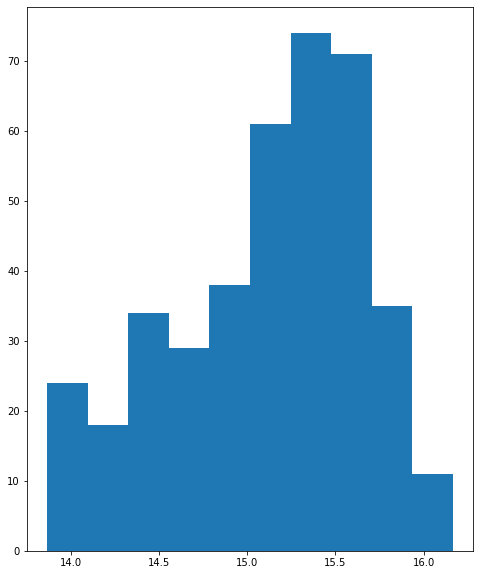

In [69]:
plt.hist(np.log(season18['Cap Hit']))

In [6]:
#season18=season18[season18['Cap Hit']>1000000]
#season18=season18.reset_index(drop=True)

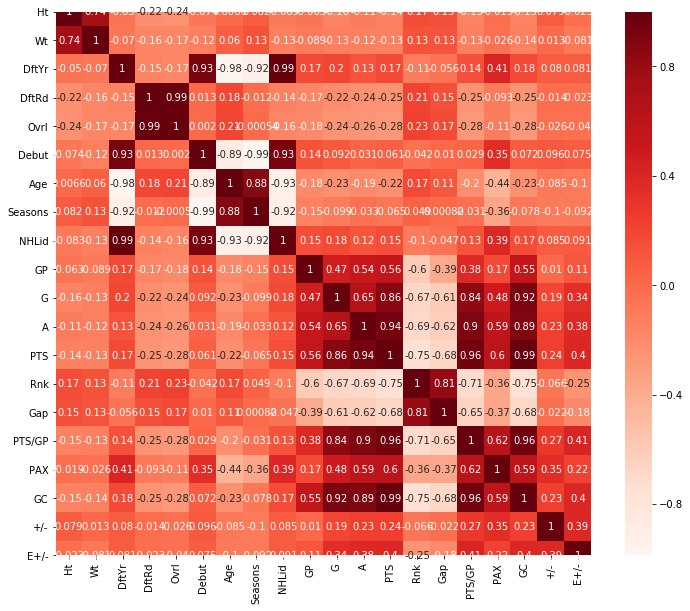

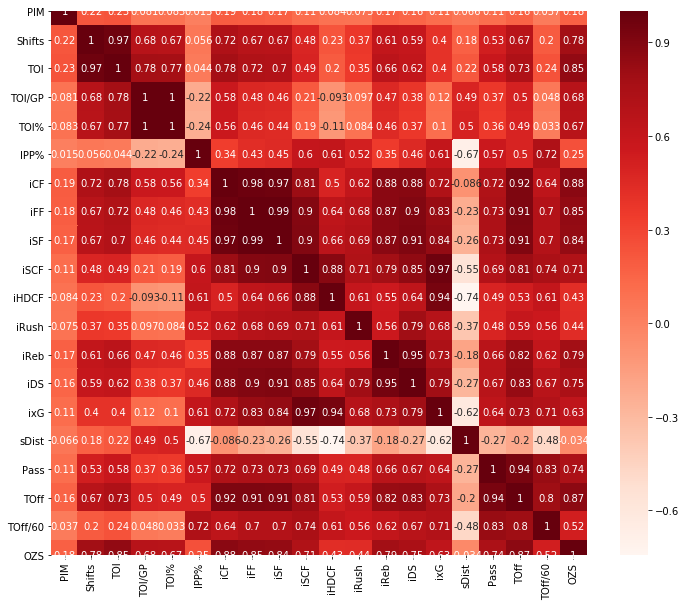

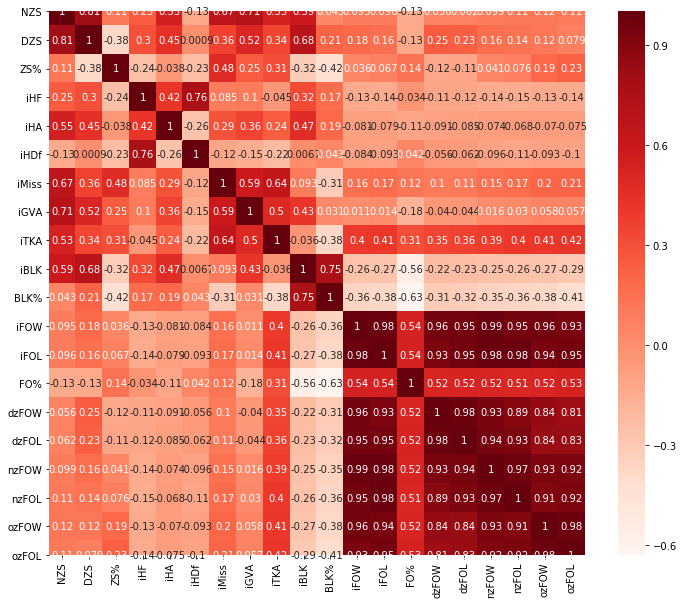

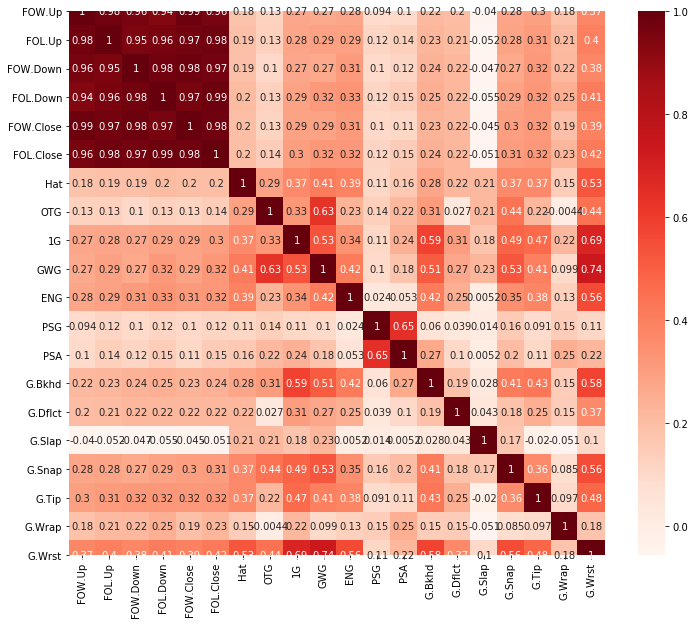

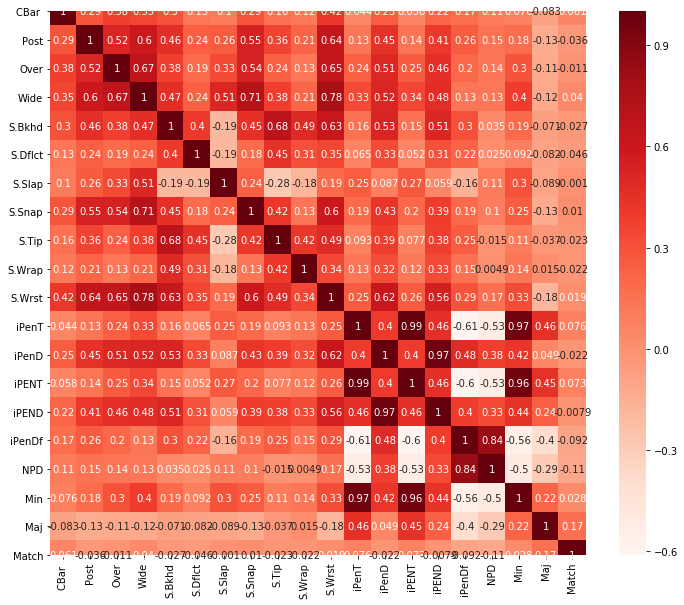

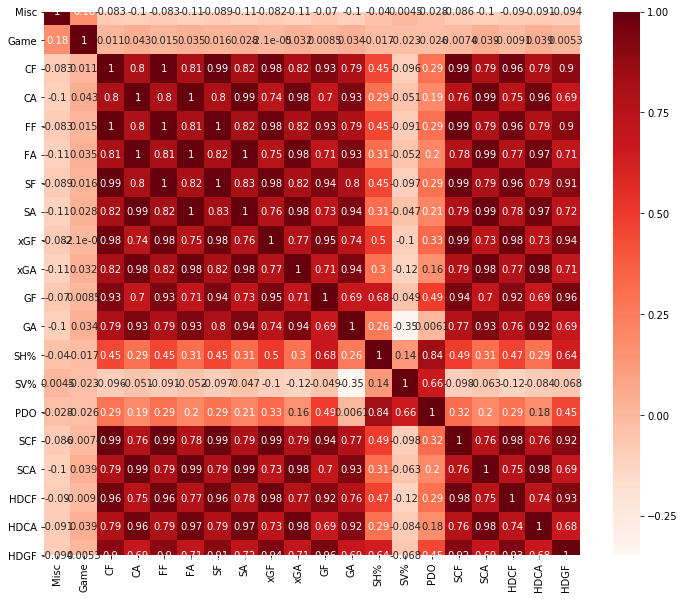

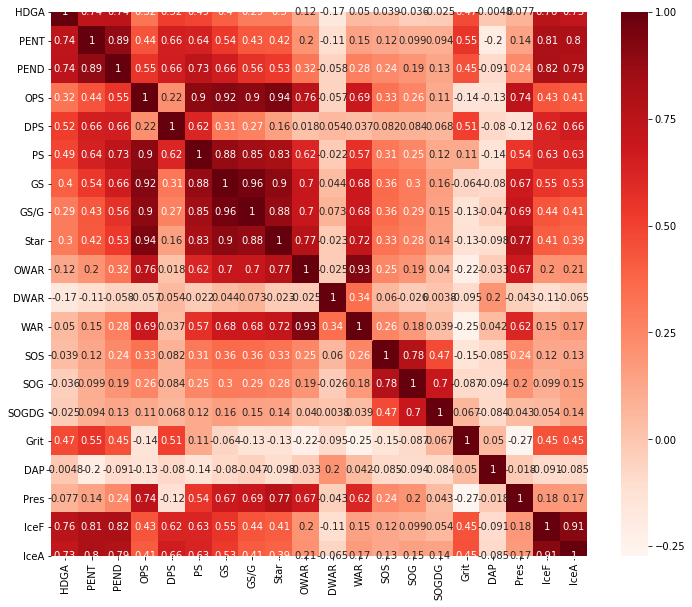

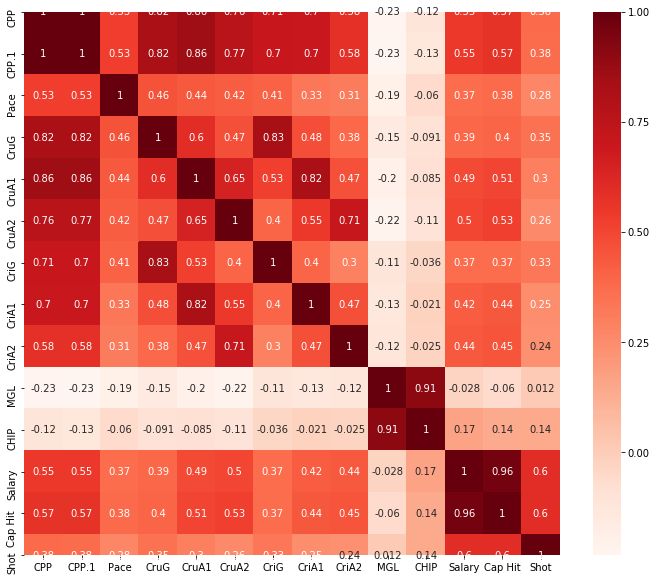

In [7]:
corr = season18.corr()
for i in range(0,int(season18.shape[1]/20)):
    plt.figure(figsize=(12,10))
    sns.heatmap(corr.loc[corr.columns[i*20:i*20+20],corr.columns[i*20:i*20+20]], annot=True, cmap=plt.cm.Reds)
    plt.show()

In [8]:
modelSeason18=season18.copy()
modelSeason18.reset_index(drop=True,inplace=True)

In [9]:
names=modelSeason18['CorsicaID']

In [10]:
modelSeason18.drop(modelSeason18.columns[modelSeason18.dtypes=='object'], axis=1, inplace=True)
modelSeason18.drop(['Born'], axis=1, inplace=True)

In [11]:
modelSeason18.shape

(395, 154)

In [12]:
modelSeason18.fillna('?',inplace=True)

In [13]:
for col in modelSeason18.columns:
    if modelSeason18[col].dtype == object:
        count = 0
        count = [count + 1 for x in modelSeason18[col] if x == '?']
        print(col + ' ' + str(sum(count)))

DftYr 36
DftRd 36
Ovrl 36
SOS 228
SOG 228
SOGDG 228
MGL 131
CHIP 131


In [14]:
modelSeason18.drop(['SOS','SOG','SOGDG','MGL','CHIP','Salary'], axis=1, inplace=True)

In [15]:
for column in modelSeason18.columns:
    modelSeason18.loc[modelSeason18[column] == '?', column] = np.nan
modelSeason18.dropna(axis = 0, inplace = True)
modelSeason18X=modelSeason18.drop(['Cap Hit','NHLid'], axis=1)
modelSeason18Y=modelSeason18[['Cap Hit']]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


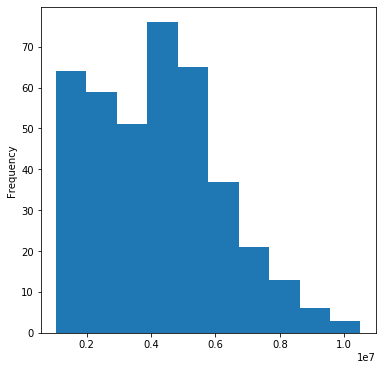

In [16]:
fig = plt.figure(figsize=(6,6)) # define plot area
ax = fig.gca()
season18['Cap Hit'].plot.hist(ax = ax, bins = 10)

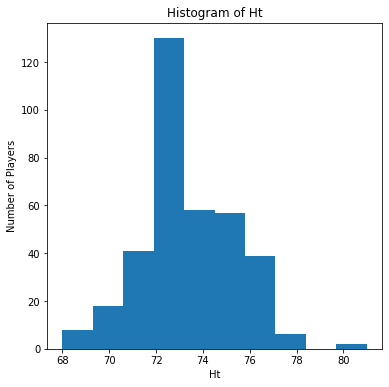

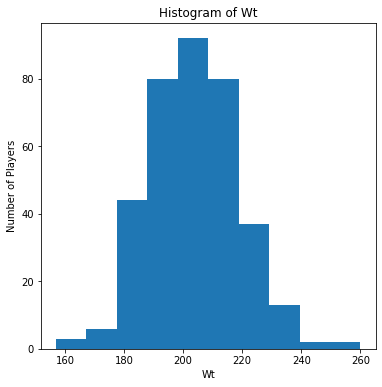

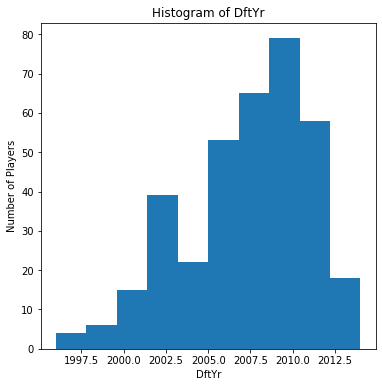

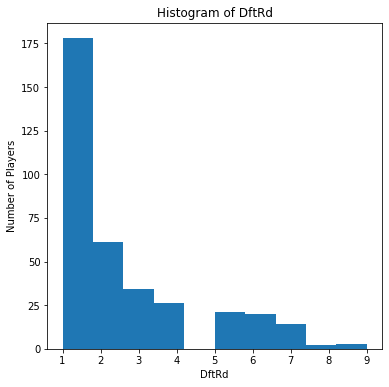

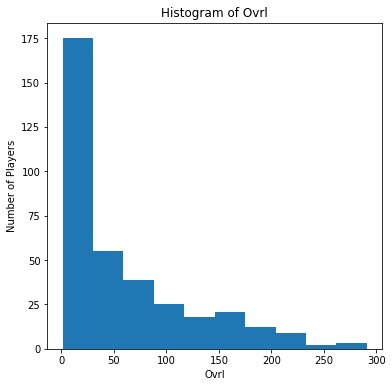

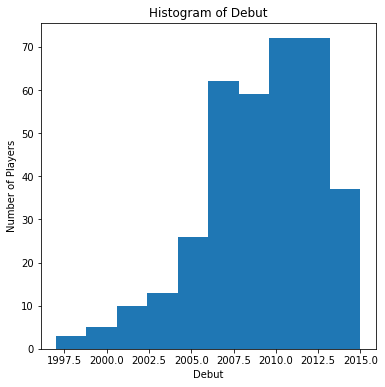

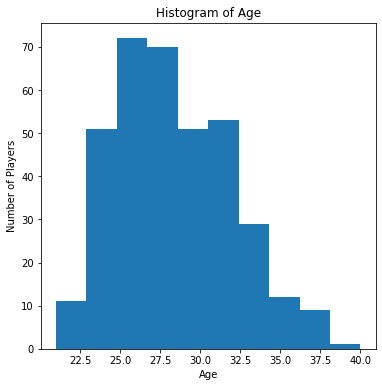

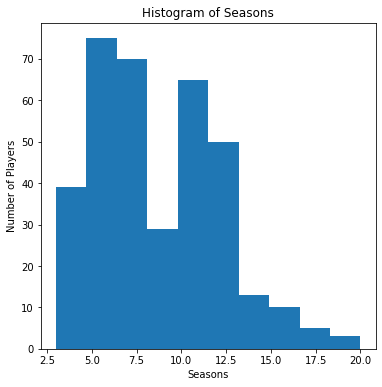

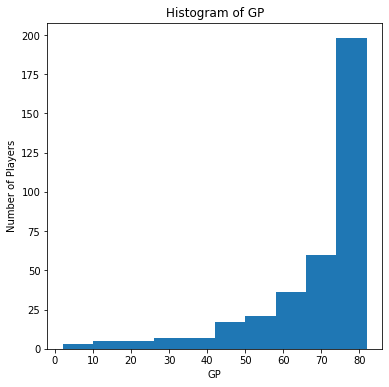

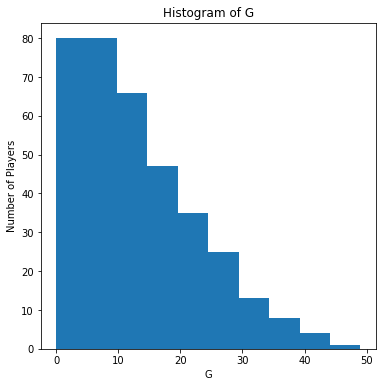

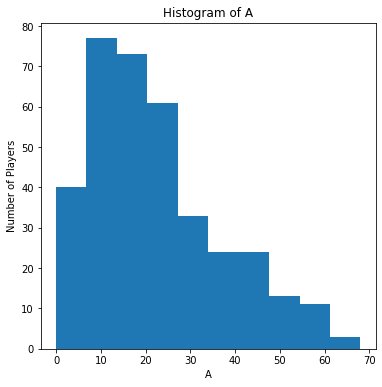

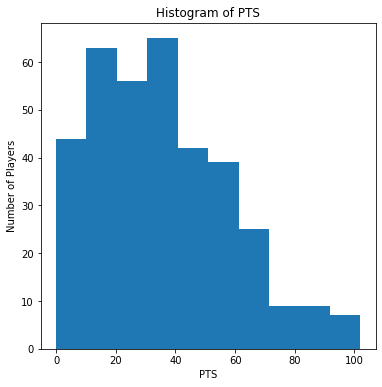

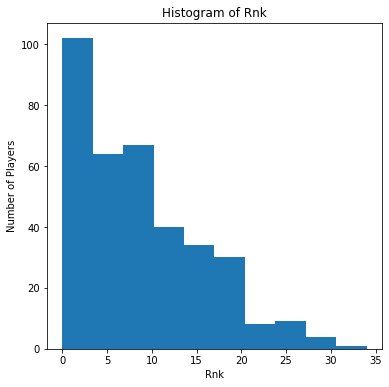

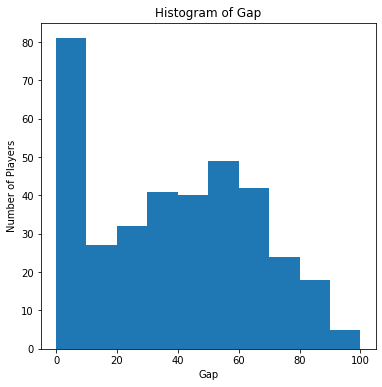

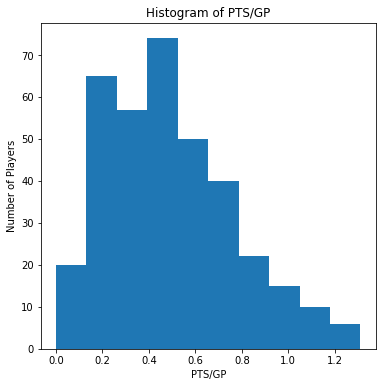

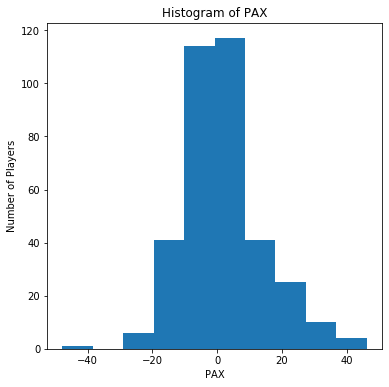

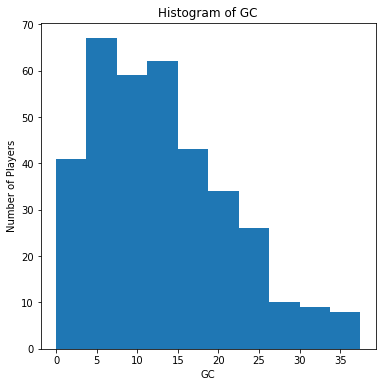

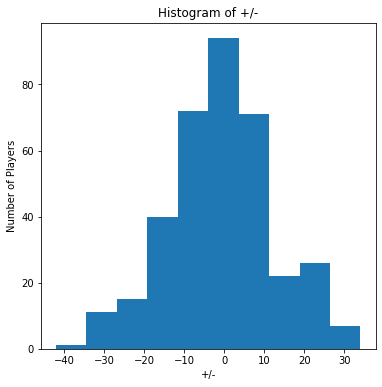

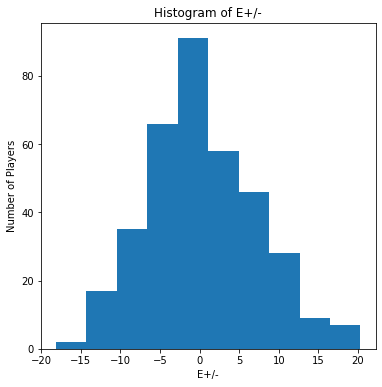

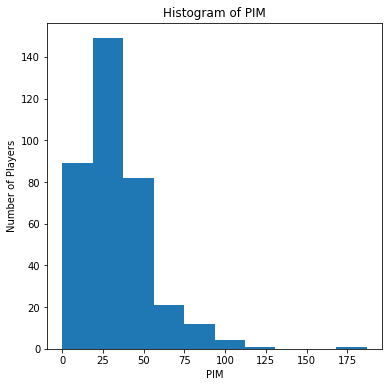

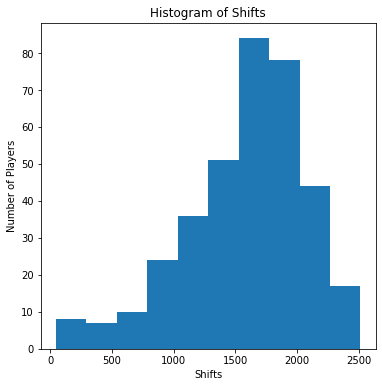

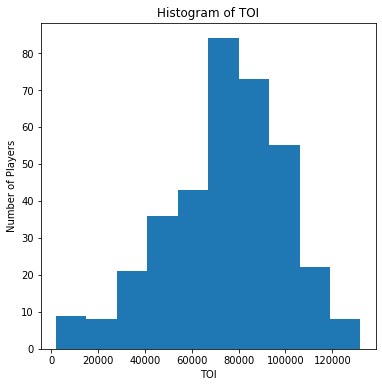

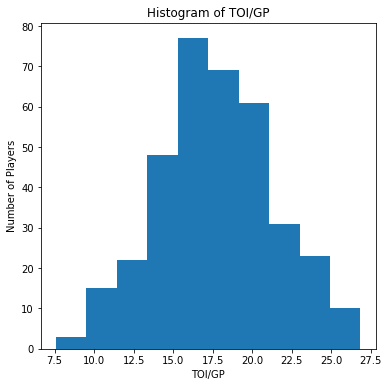

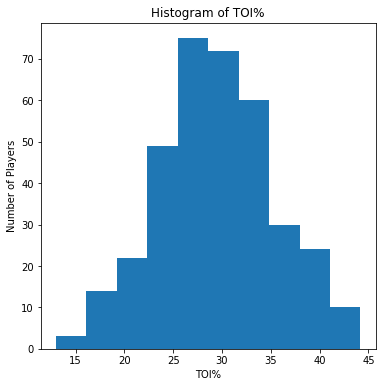

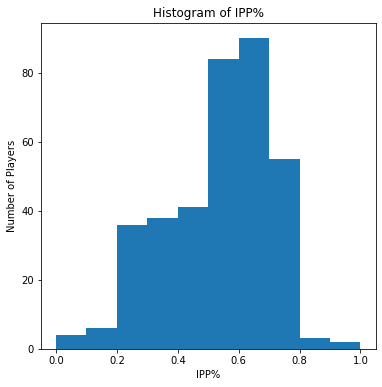

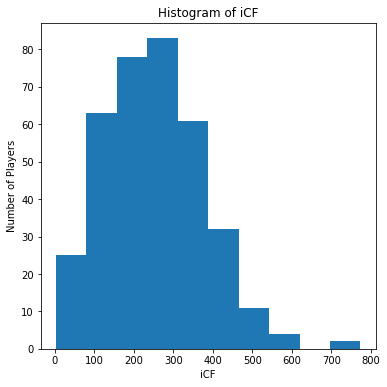

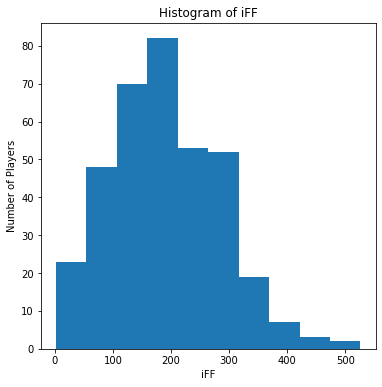

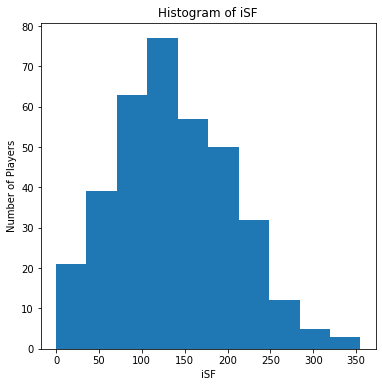

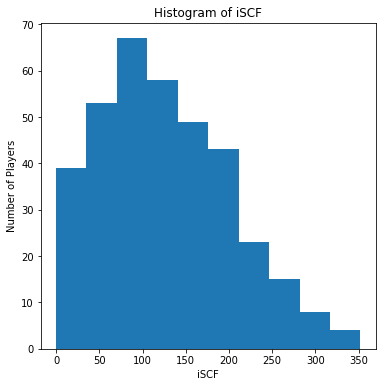

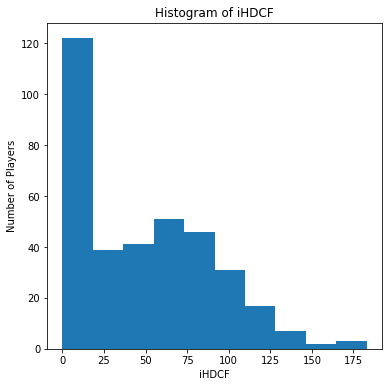

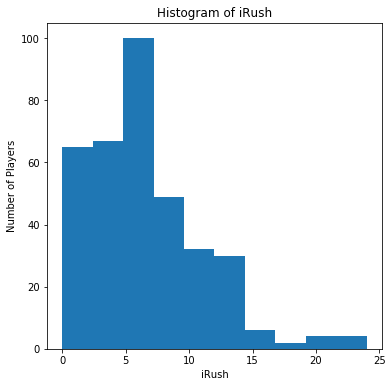

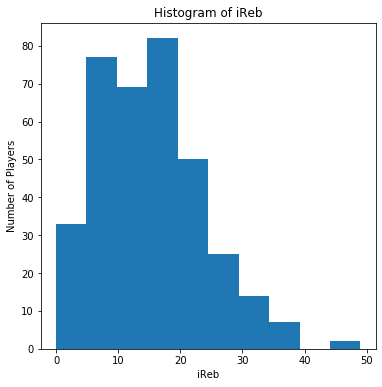

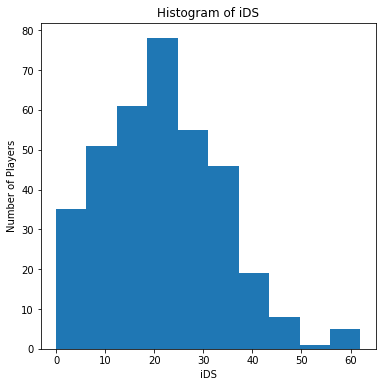

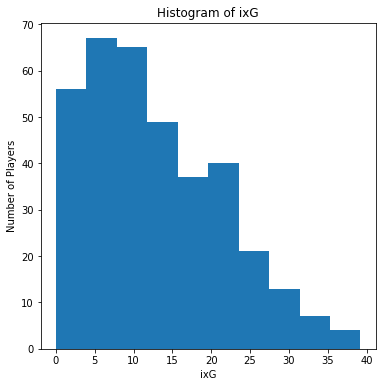

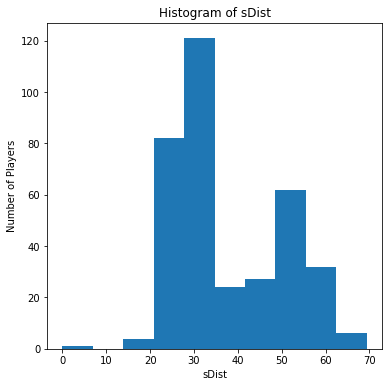

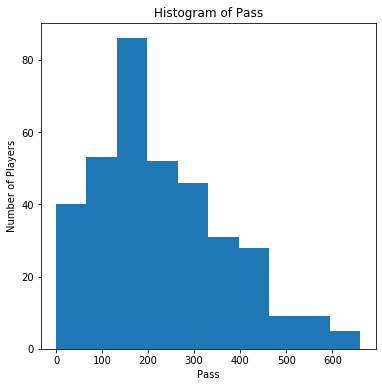

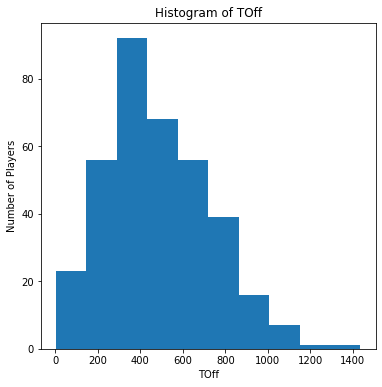

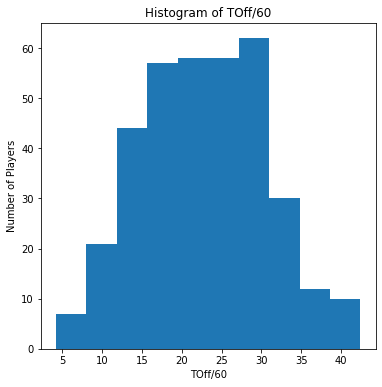

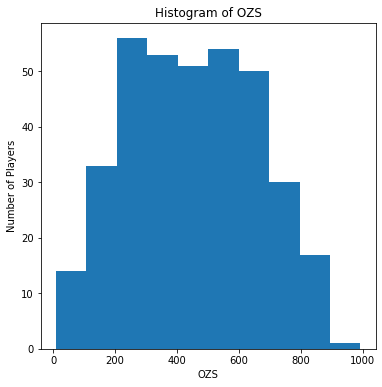

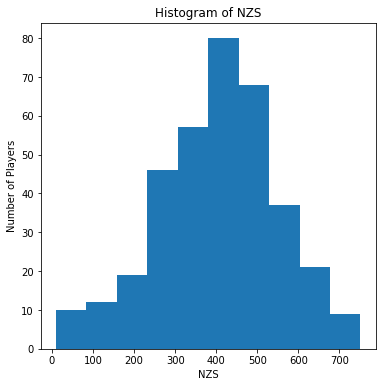

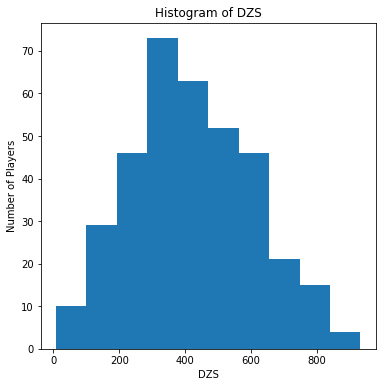

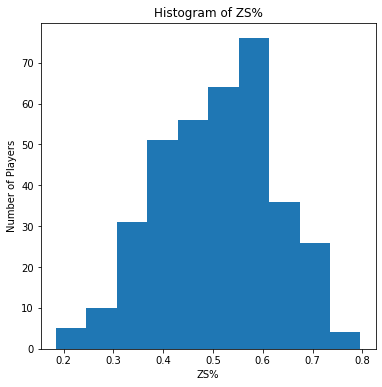

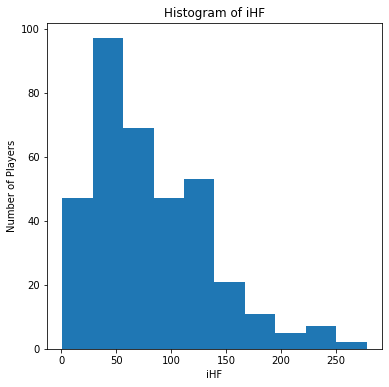

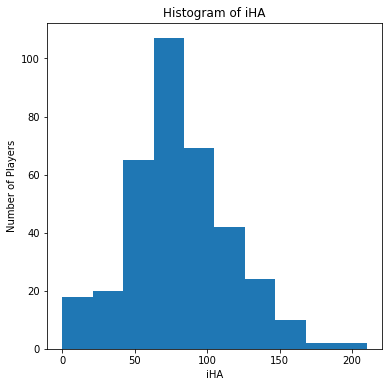

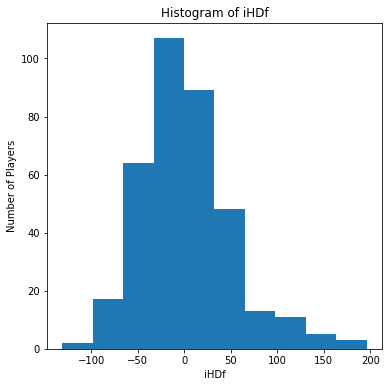

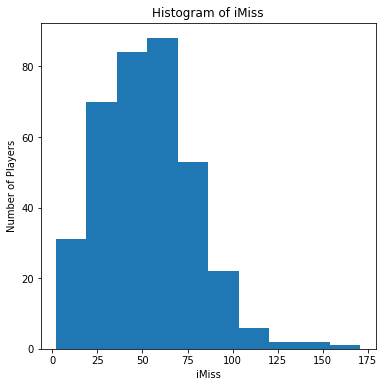

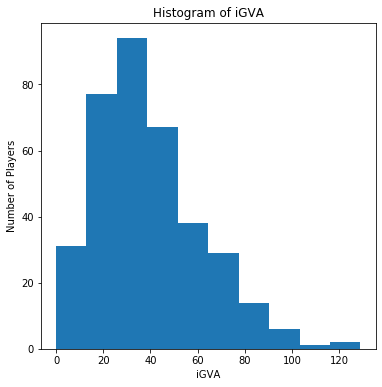

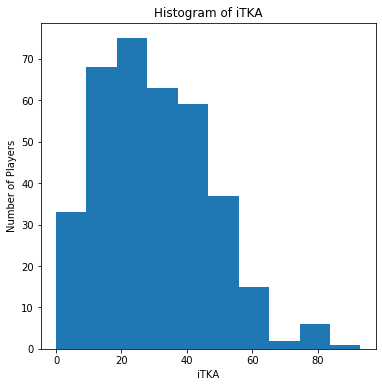

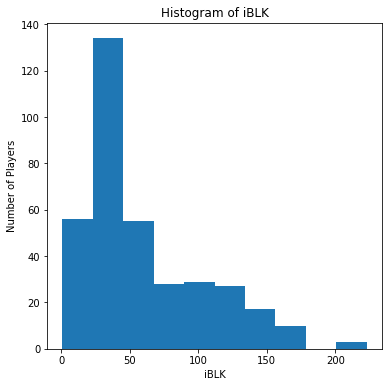

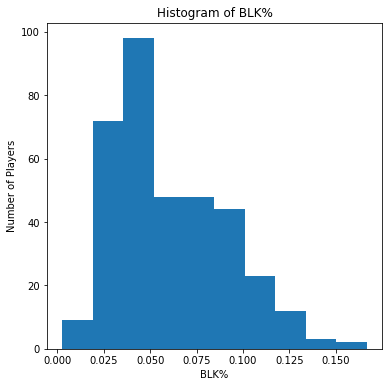

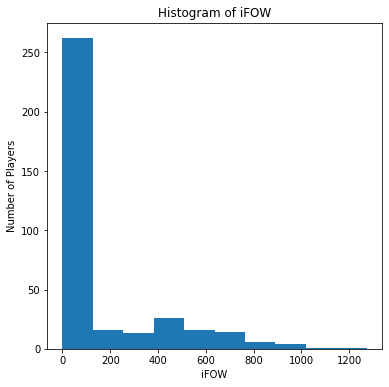

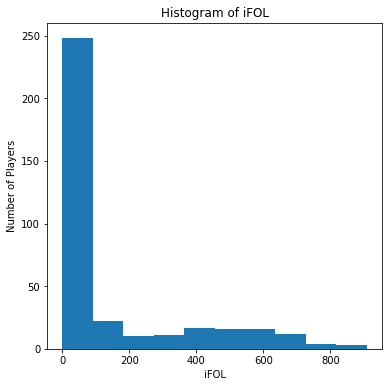

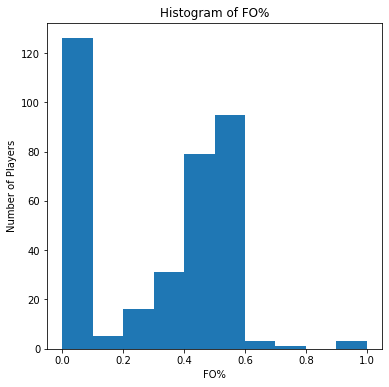

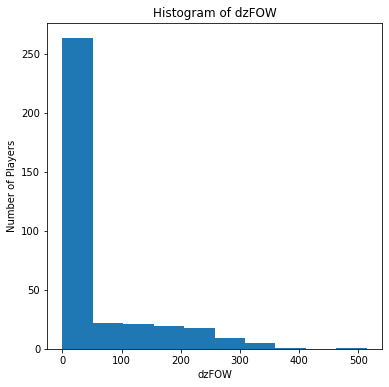

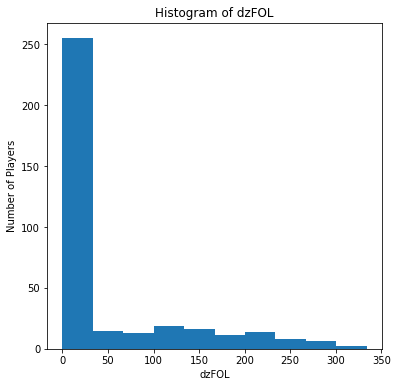

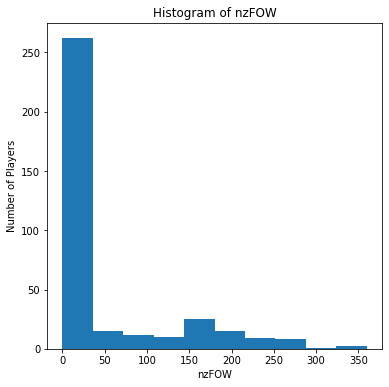

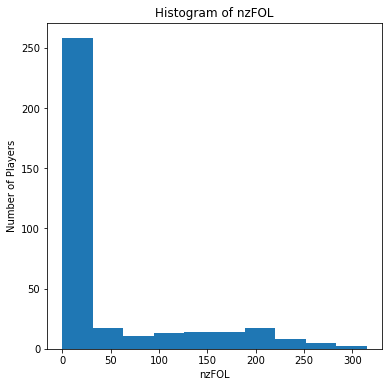

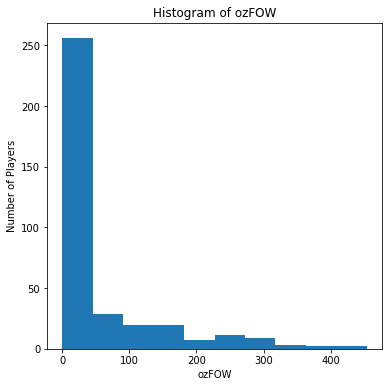

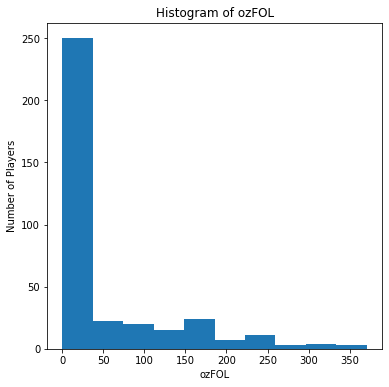

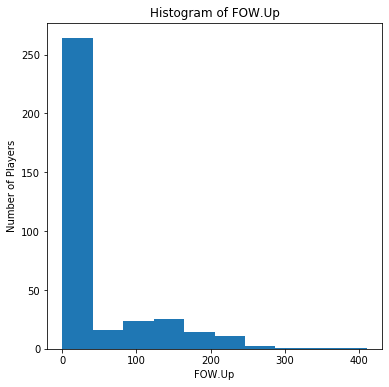

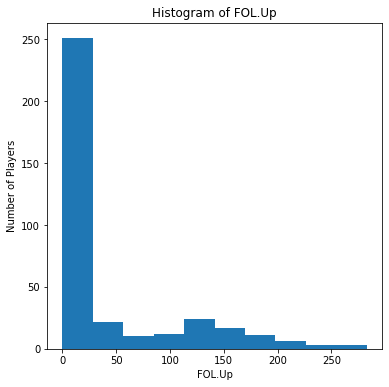

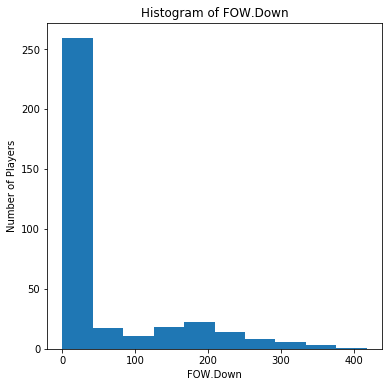

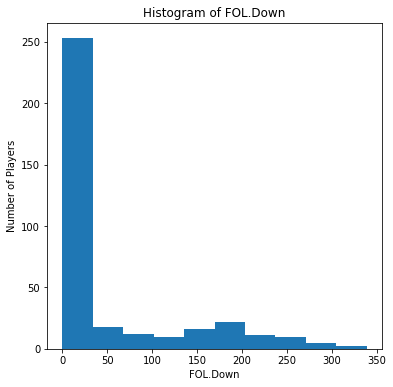

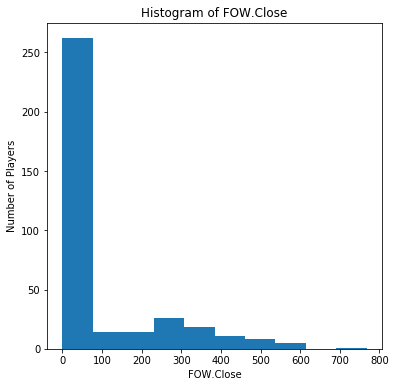

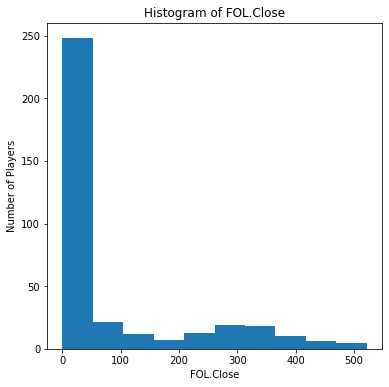

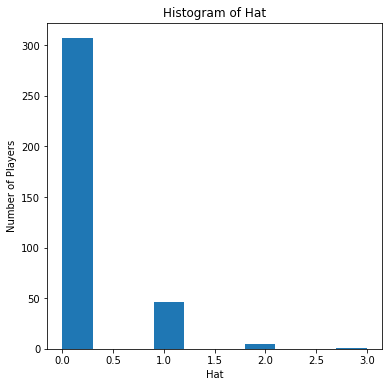

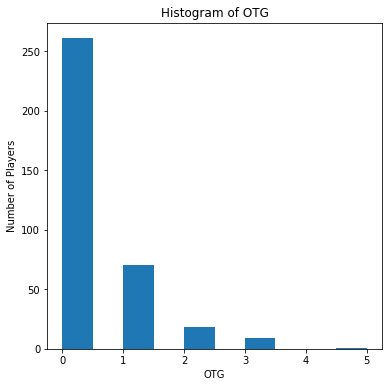

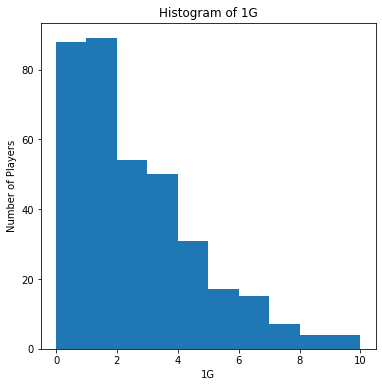

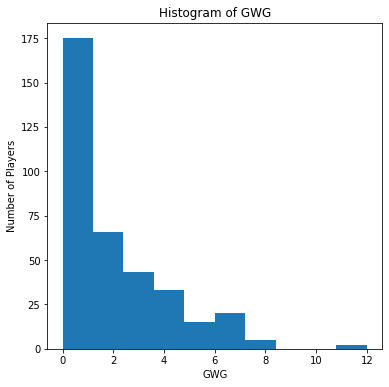

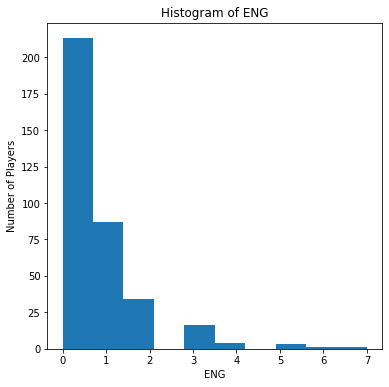

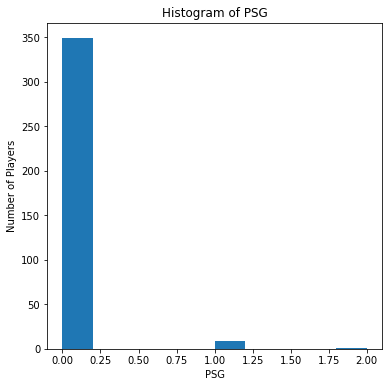

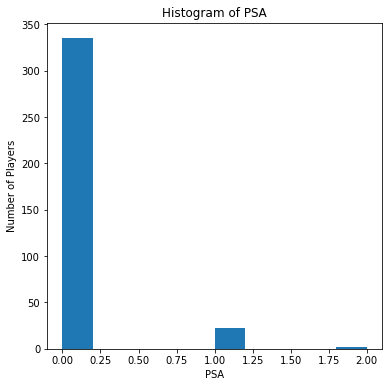

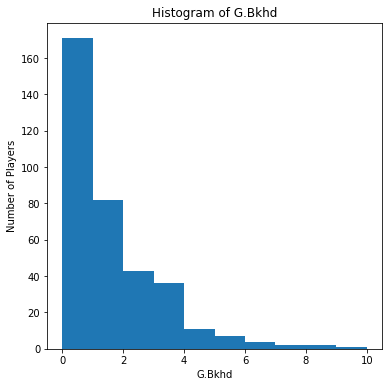

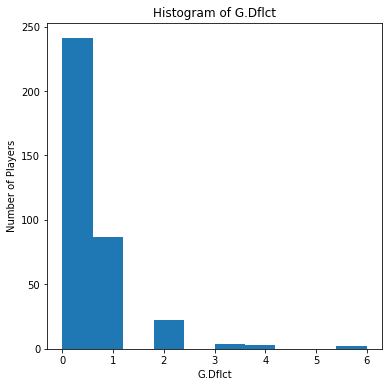

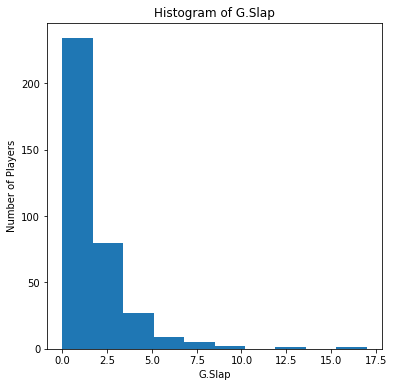

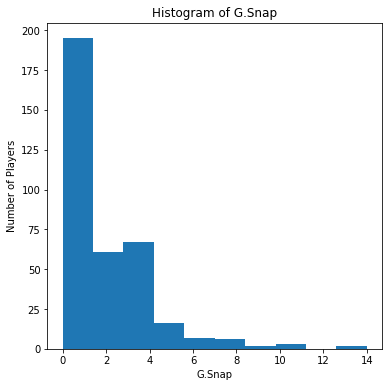

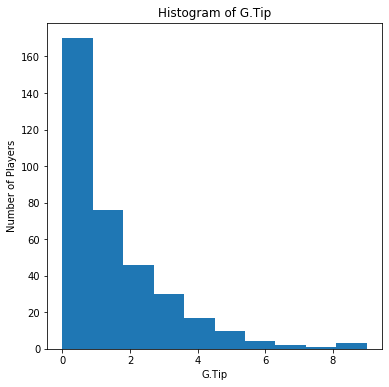

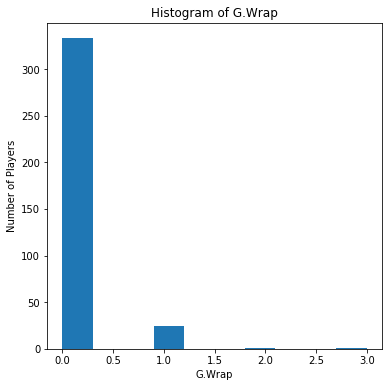

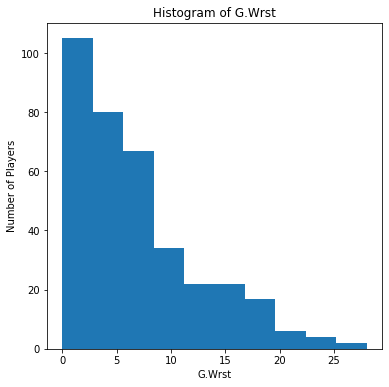

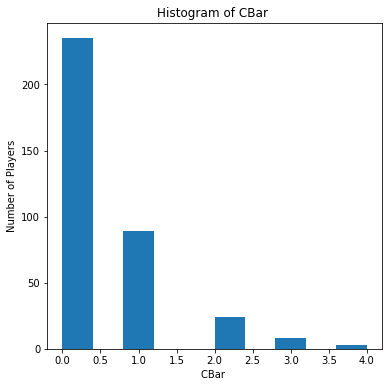

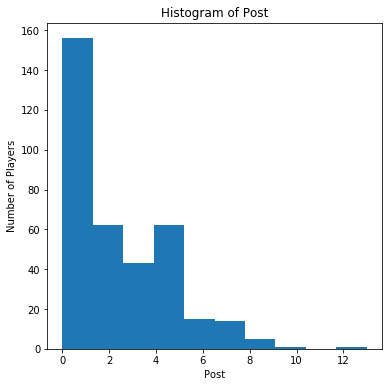

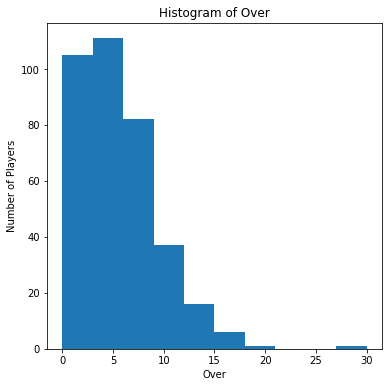

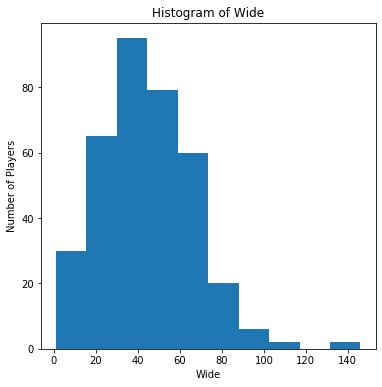

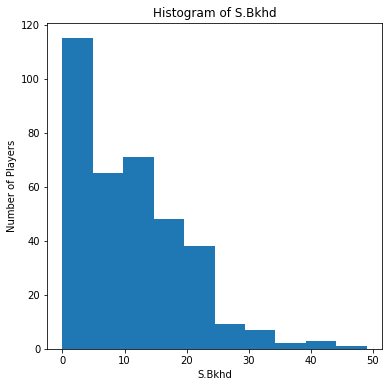

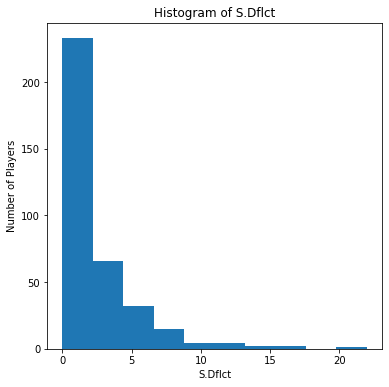

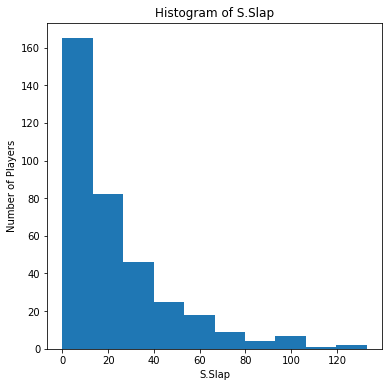

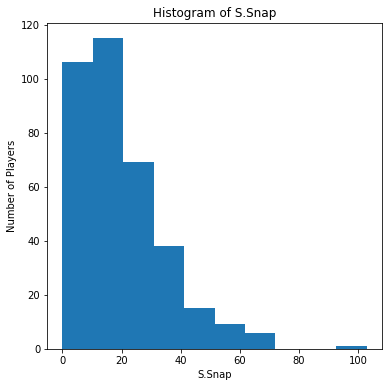

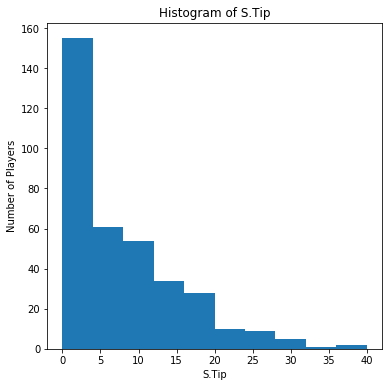

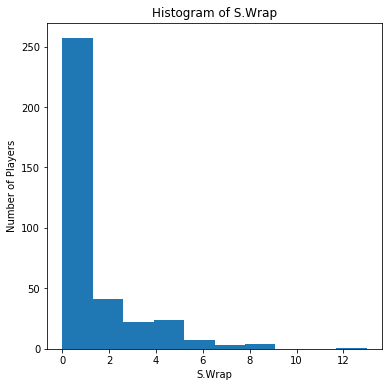

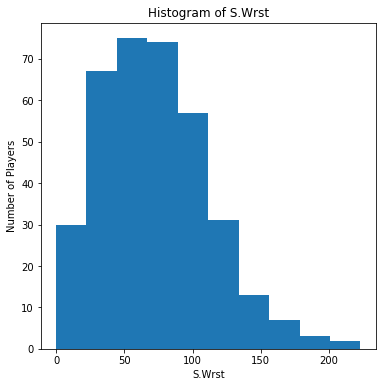

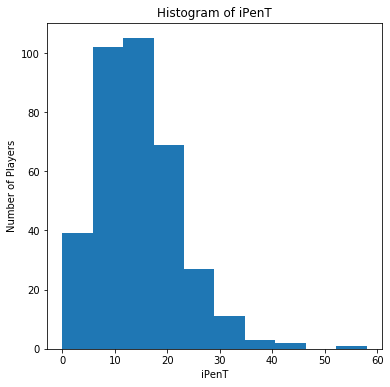

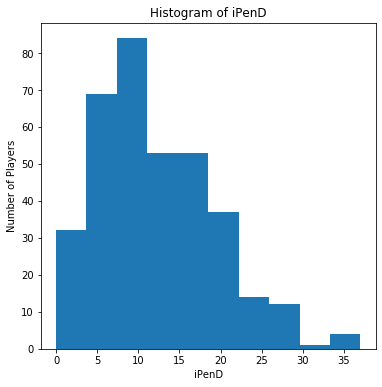

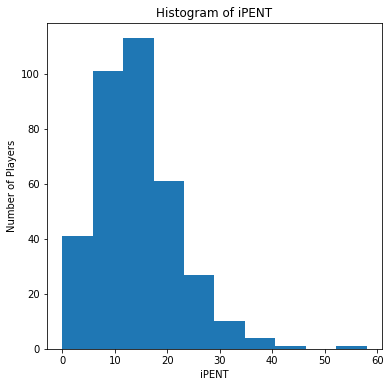

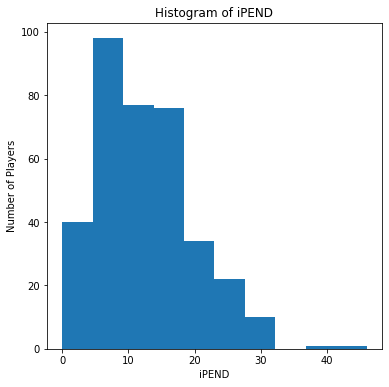

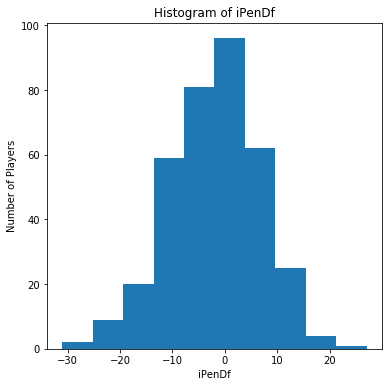

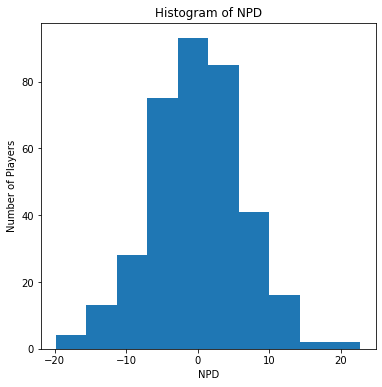

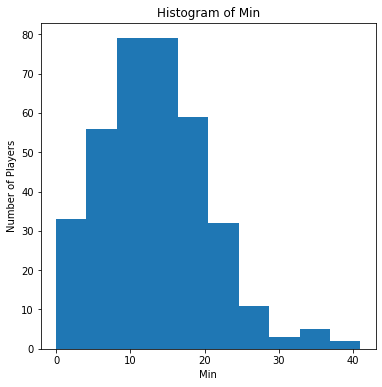

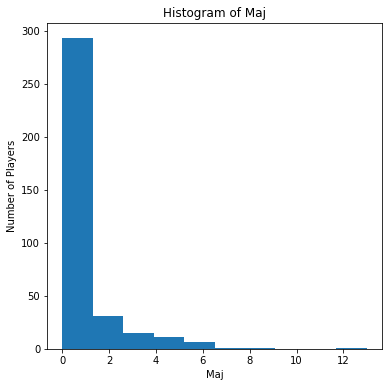

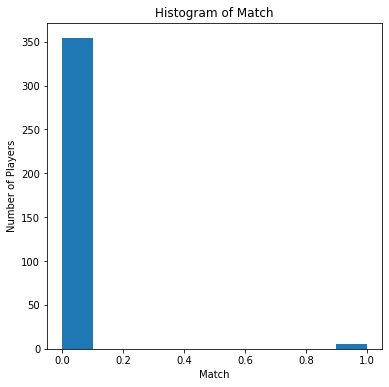

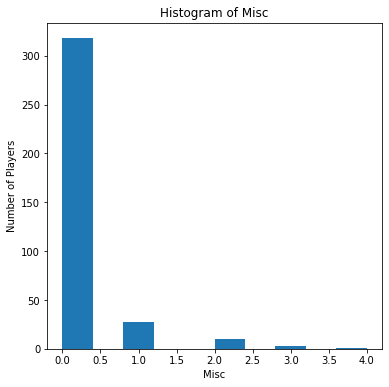

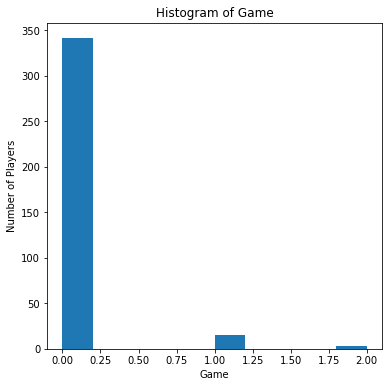

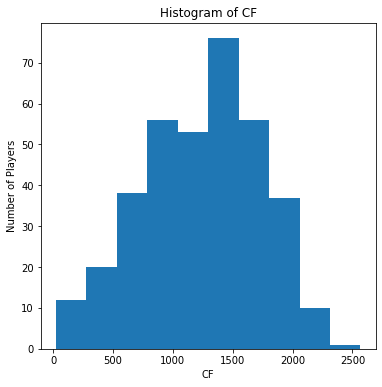

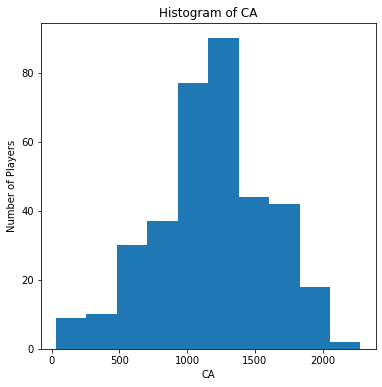

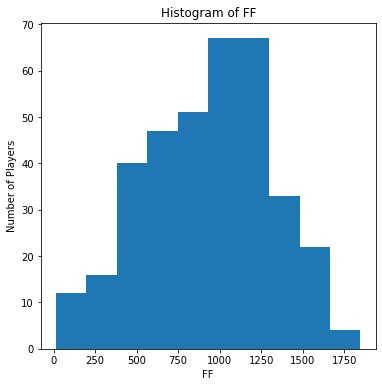

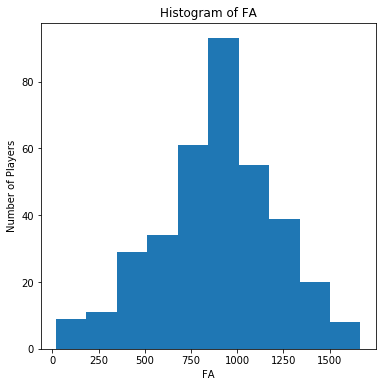

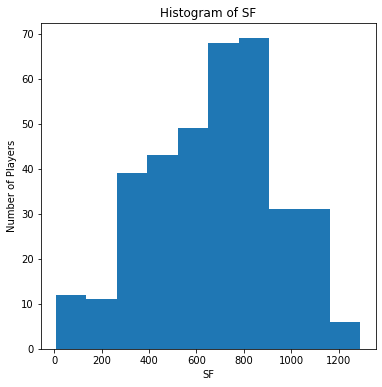

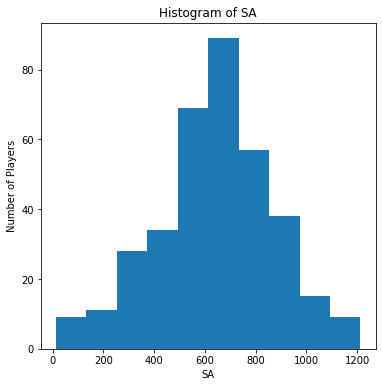

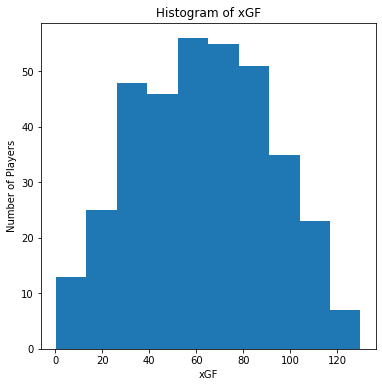

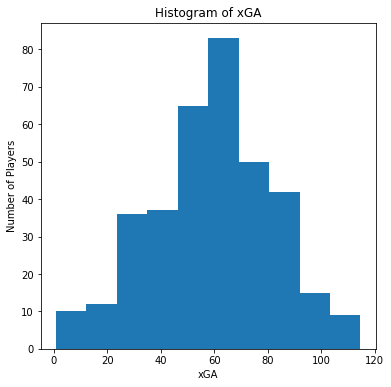

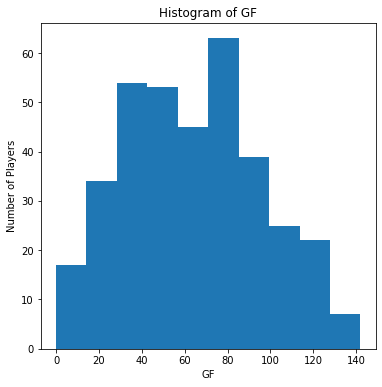

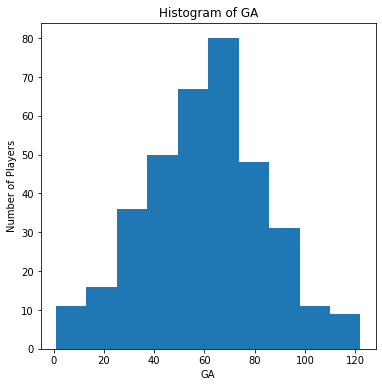

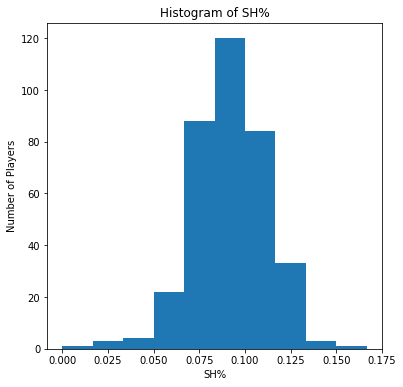

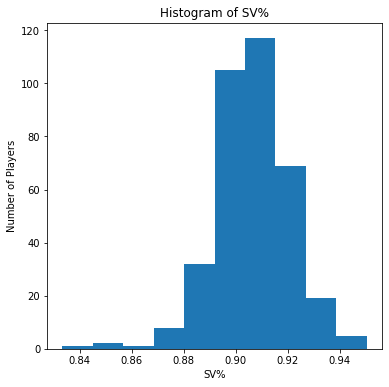

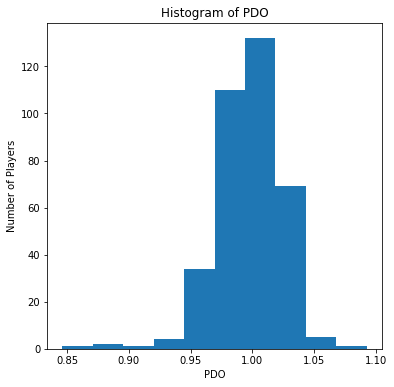

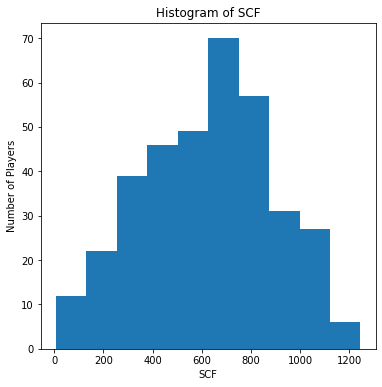

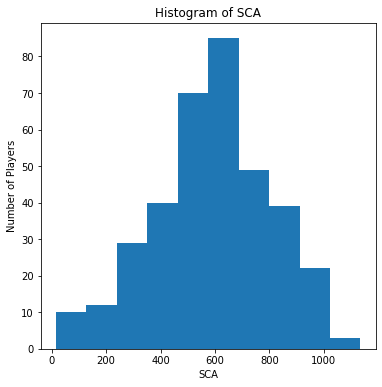

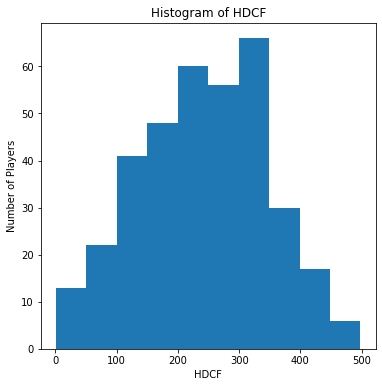

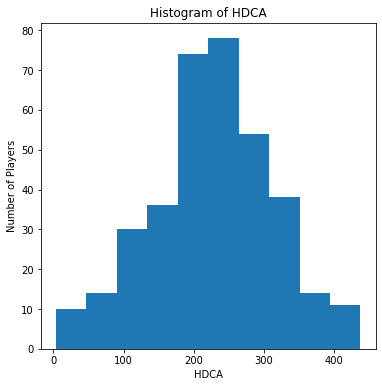

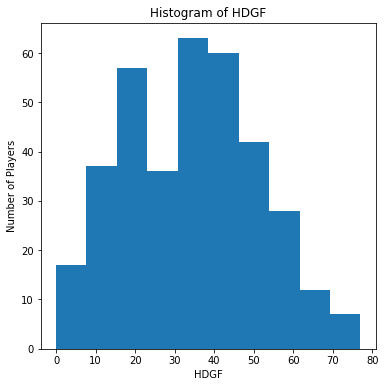

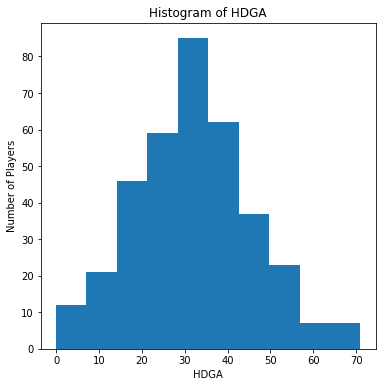

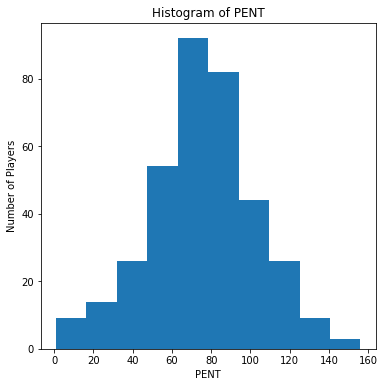

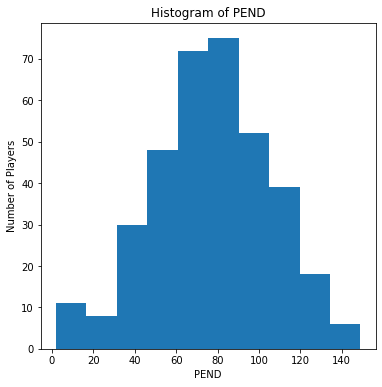

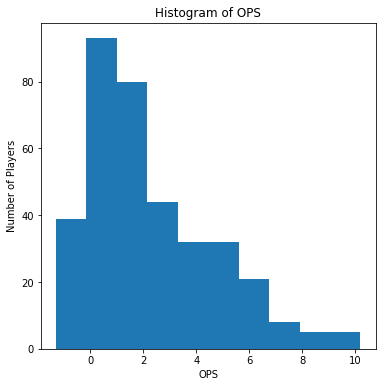

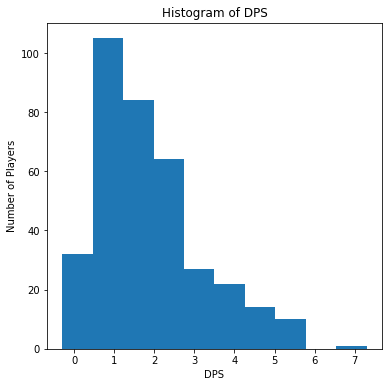

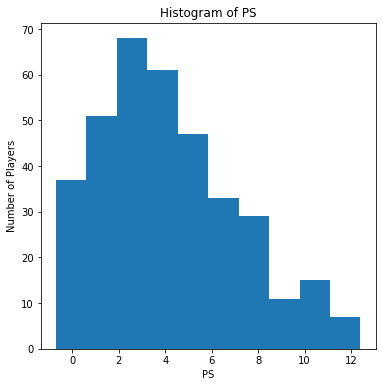

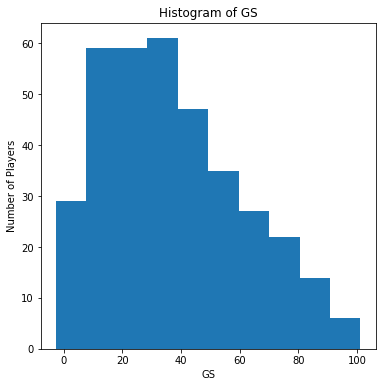

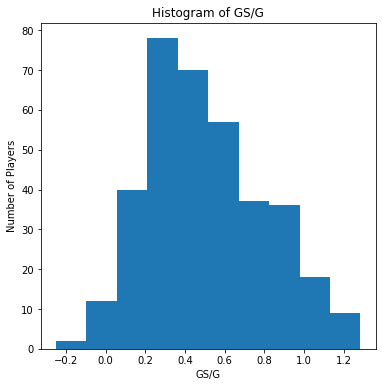

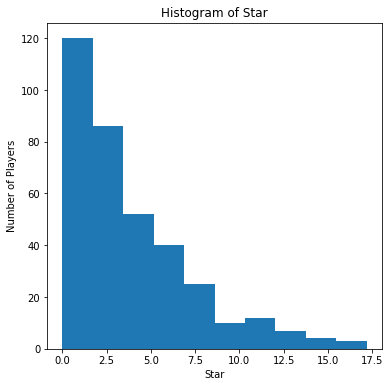

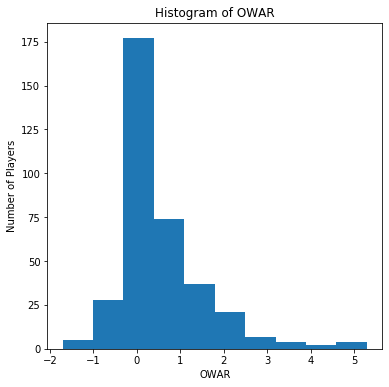

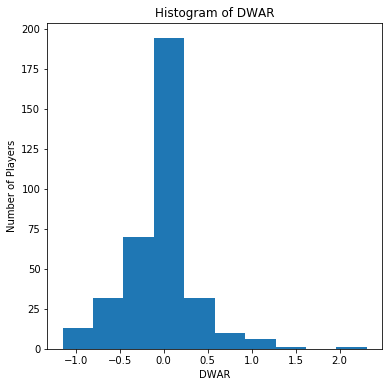

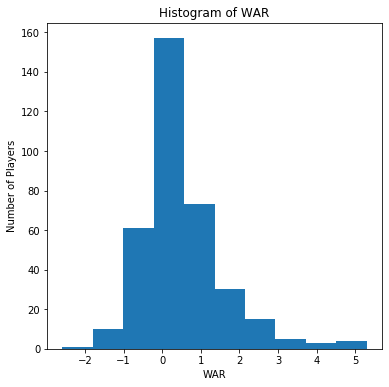

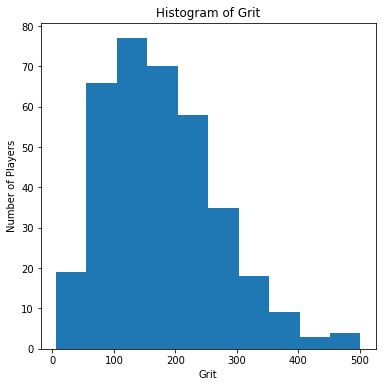

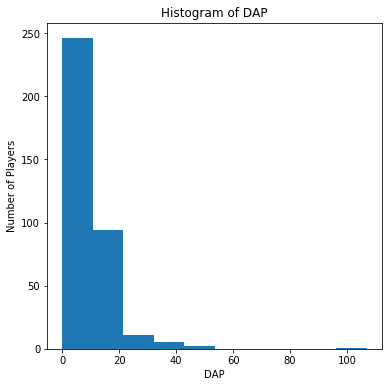

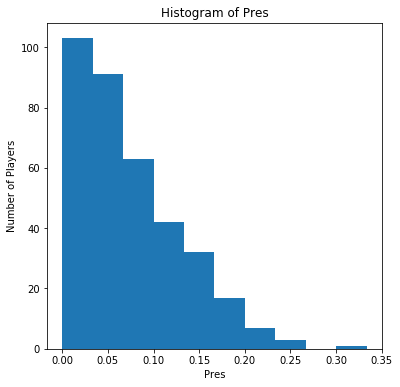

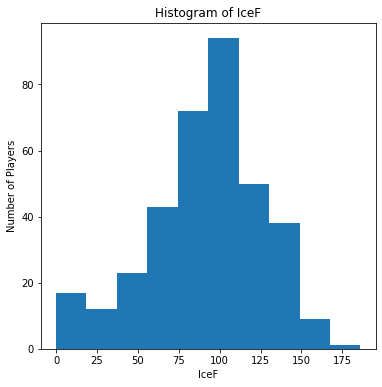

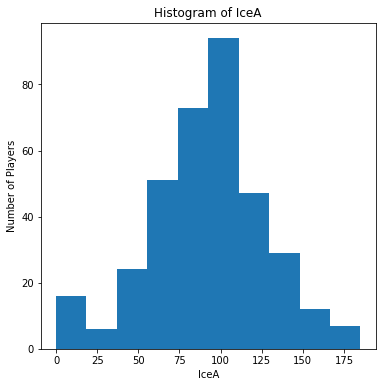

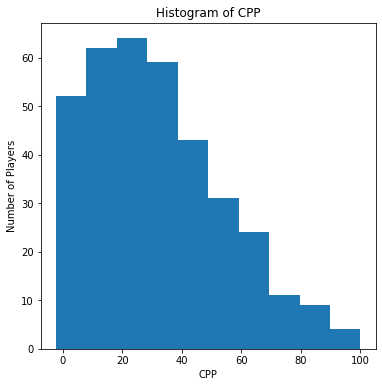

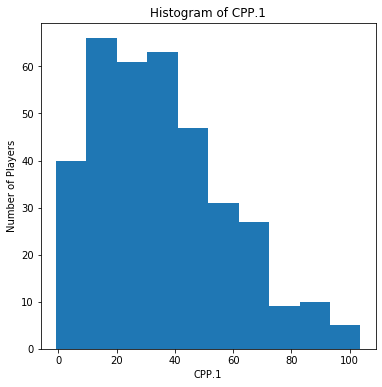

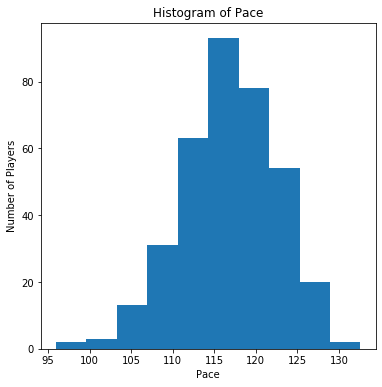

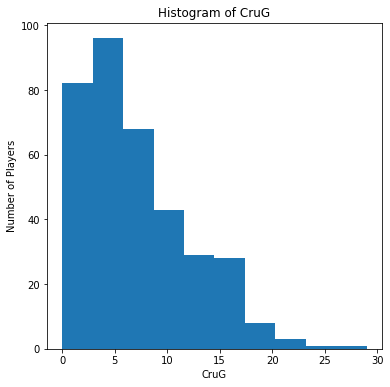

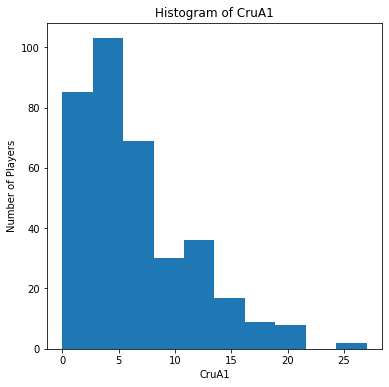

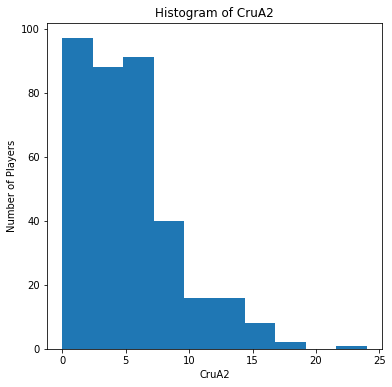

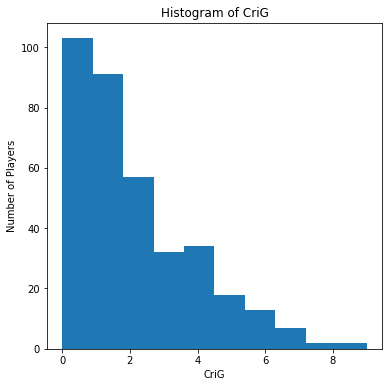

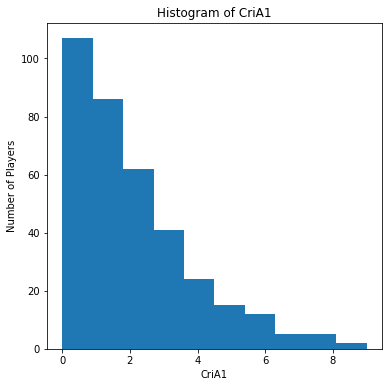

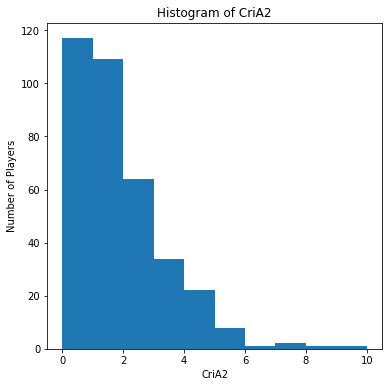

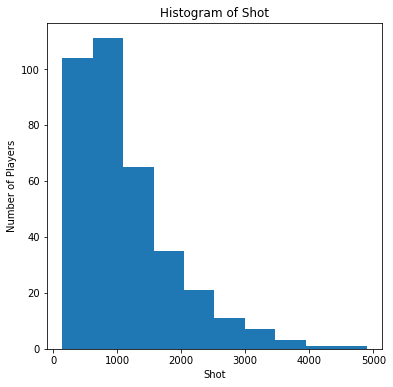

In [17]:
def plot_histogram(season18, cols, bins = 10):
    for col in cols:
        fig = plt.figure(figsize=(6,6)) # define plot area
        ax = fig.gca() # define axis    
        season18[col].plot.hist(ax = ax, bins = bins) # Use the plot.hist method on subset of the data frame
        ax.set_title('Histogram of ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel('Number of Players')# Set text for y axis
        plt.show()
        
num_cols = list(modelSeason18X.columns)
plot_histogram(modelSeason18X, num_cols)

In [18]:
season18.to_csv('clean18.csv')

In [19]:
from sklearn import preprocessing

x = modelSeason18X.values
normalized = preprocessing.normalize(x)
modelSeason18X = pd.DataFrame(normalized)

In [20]:
y=modelSeason18['Cap Hit']
modelSeason18X.to_csv('clean18x.csv',index=False)
y.to_csv('clean18y.csv',index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
#Backward Elimination
cols = list(modelSeason18X.columns)
pmax = 1
y=modelSeason18['Cap Hit']
count=0
while (len(cols)>0):
    if(count%100==0):
        print(count)
    count=count+1
    p= []
    X_1 = modelSeason18X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(list(y),X_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)  
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


0
100
[1, 4, 7, 8, 11, 12, 15, 19, 33, 36, 38, 39, 43, 44, 48, 88, 107, 109, 111, 113, 114, 117, 118, 126, 129, 131, 136, 138, 144]


In [22]:
season18.columns[selected_features_BE]

Index(['City', 'Nat', 'DftYr', 'DftRd', 'Debut', 'Age', 'CorsicaID',
       'Position', 'Shifts', 'TOI%', 'iCF', 'iFF', 'iRush', 'iReb', 'Pass',
       'G.Snap', 'iPenDf', 'Min', 'Match', 'Game', 'CF', 'FA', 'SF', 'PDO',
       'HDCF', 'HDGF', 'DPS', 'GS', 'SOS'],
      dtype='object')

In [23]:
len(selected_features_BE)

29

In [24]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [25]:
X_train, X_test, y_train, y_test = train_test_split(modelSeason18X,y, test_size = 0.2, random_state = 0)

In [26]:
X_train.to_csv('X_train.csv',index=False)
X_test.to_csv('X_test.csv',index=False)
y_train.to_csv('y_train.csv',index=False)
y_test.to_csv('y_test.csv',index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [27]:
X2_train=X_train[[5, 8, 14, 15, 20, 21, 22, 27, 38, 39, 40, 42, 43, 51, 57, 85, 89, 90, 91, 94, 96, 104, 105, 107, 110, 118, 133, 136, 143]]
y2_train=y_train.copy()
X2_test=X_test[[5, 8, 14, 15, 20, 21, 22, 27, 38, 39, 40, 42, 43, 51, 57, 85, 89, 90, 91, 94, 96, 104, 105, 107, 110, 118, 133, 136, 143]]
y2_test=y_test.copy()

In [28]:
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_test,y_test))
coef = pd.Series(reg.coef_, index = X_test.columns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90793410953.8125, tolerance: 77817583161.92885
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103248497004.9375, tolerance: 77817583161.92885
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

Best alpha using built-in LassoCV: 26.439667
Best score using built-in LassoCV: 0.551511


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74270631347.1875, tolerance: 72603598501.76291
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78405047985.875, tolerance: 72603598501.76291
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76529430756.25, tolerance: 72603598501.76291
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to 

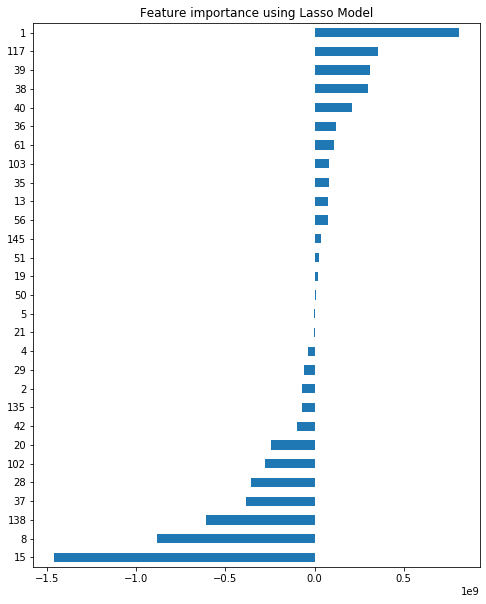

In [29]:
imp_coef = coef.sort_values()
imp_coef=imp_coef[imp_coef!=0]
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

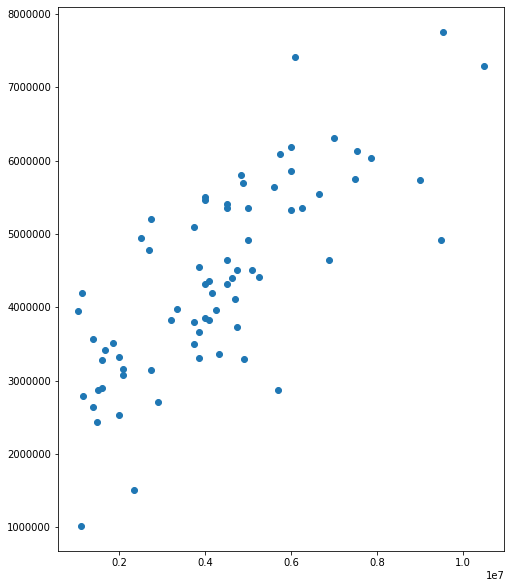

In [30]:
#fig = go.Figure()
#fig.add_trace(go.Scatter(y_test,reg.predict(X_test))
#fig.add_trace(go.line()
plt.scatter(y_test,reg.predict(X_test))

(array([ 1.,  2.,  1.,  5.,  7., 17., 14., 15.,  6.,  4.]),
 array([-63612.59566252, -52988.09448676, -42363.593311  , -31739.09213524,
        -21114.59095949, -10490.08978373,    134.41139203,  10758.91256779,
         21383.41374355,  32007.91491931,  42632.41609507]),
 <a list of 10 Patch objects>)

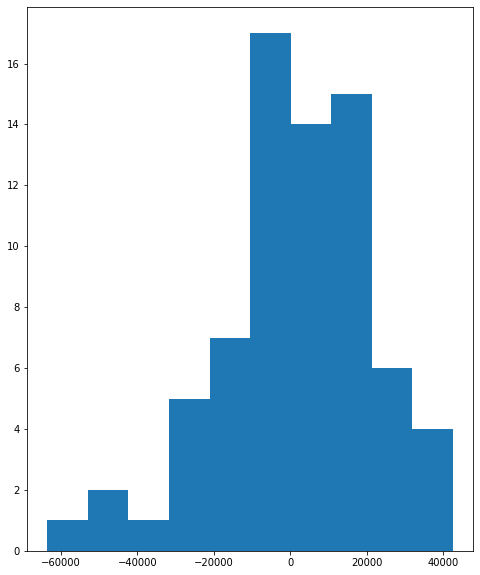

In [31]:
plt.hist((reg.predict(X_test)-y_test)/len(y_test))

(array([22., 15., 13., 11.,  3.,  2.,  4.,  1.,  0.,  1.]),
 array([  434.07466891,  6751.92676827, 13069.77886763, 19387.63096699,
        25705.48306635, 32023.33516572, 38341.18726508, 44659.03936444,
        50976.8914638 , 57294.74356316, 63612.59566252]),
 <a list of 10 Patch objects>)

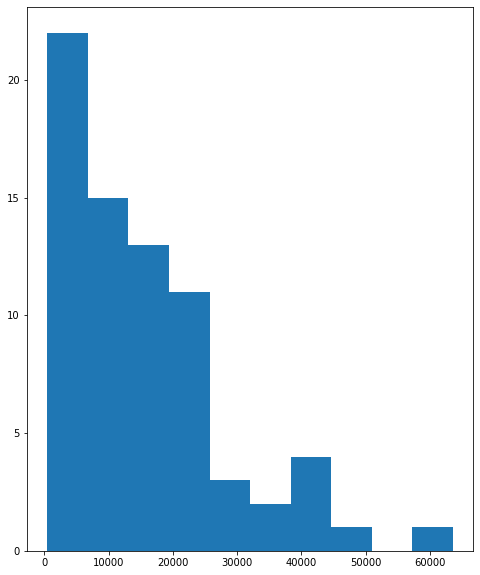

In [32]:
plt.hist((abs(reg.predict(X_test)-y_test))/len(y_test))

In [33]:
diff=reg.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-2826495.06829156
143809.8253772026
2438321.6938918037
22


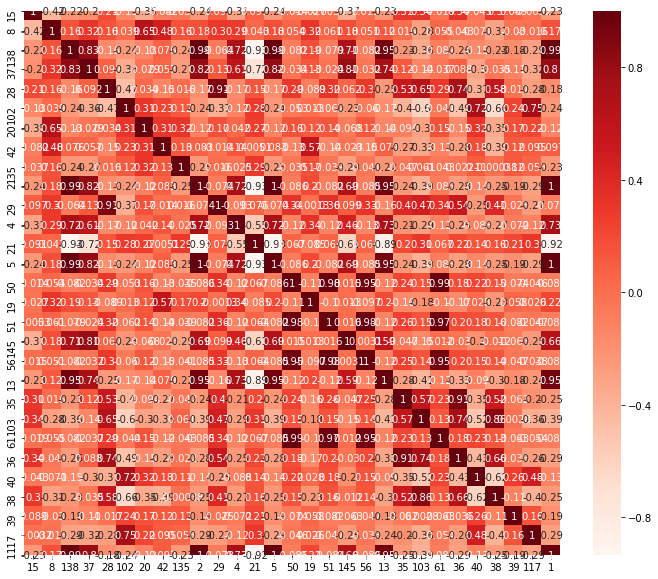

In [34]:
corr = modelSeason18X[imp_coef.index].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr.loc[corr.columns,corr.columns], annot=True, cmap=plt.cm.Reds)
plt.show()

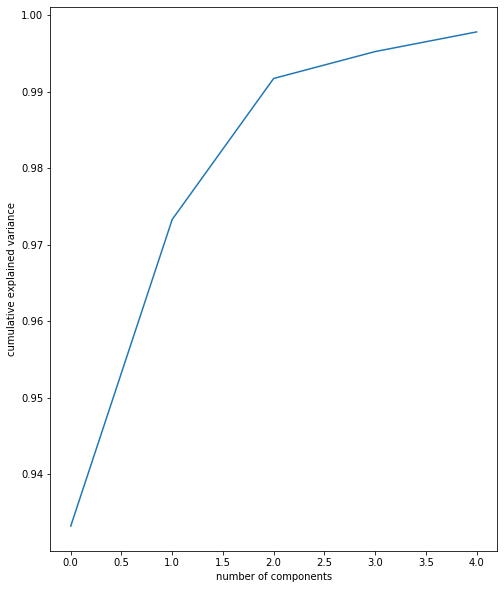

In [35]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[0:5])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [36]:
pca=PCA(2)
pca.fit(X_train)
pcatrain_x = pca.transform(X_train)
pcatest_x = pca.transform(X_test)
reg = LassoCV()
reg.fit(pcatrain_x, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [37]:
diff=reg.predict(pcatest_x)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))


-4617471.9468508465
214246.2422358282
2974403.152094858
20


In [38]:
import xgboost as xgb
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test,y_test)
params={
    'objective':"reg:squarederror",
    'eval_metric':["rmse","mae"]
}
evallist=[(dtest,'eval'),(dtrain,'train')]

In [39]:
num_round = 1000
bst=xgb.train(params,dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-rmse:3500163.00000	eval-mae:2931472.75000	train-rmse:3440736.50000	train-mae:3075491.00000
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-rmse:2799601.50000	eval-mae:2190275.25000	train-rmse:2526872.50000	train-mae:2211424.25000
[2]	eval-rmse:2322504.25000	eval-mae:1766710.25000	train-rmse:1872276.12500	train-mae:1582697.50000
[3]	eval-rmse:2047518.37500	eval-mae:1459350.50000	train-rmse:1388850.50000	train-mae:1143467.00000
[4]	eval-rmse:1885598.12500	eval-mae:1337308.62500	train-rmse:1045168.31250	train-mae:828303.25000
[5]	eval-rmse:1786833.50000	eval-mae:1304136.50000	train-rmse:788553.75000	train-mae:604628.18750
[6]	eval-rmse:1720963.25000	eval-mae:1286053.12500	train-rmse:607989.12500	train-mae:458174.87500
[7]	eval-rmse:1678909.75000	eval-mae:1267545.62500	train-rmse:473495.84375	train-mae:346359.68750
[8]	eval-rmse:1668381.87500	eval-mae:1273696.62500	train-rmse:37

[85]	eval-rmse:1614827.25000	eval-mae:1276902.00000	train-rmse:17.20942	train-mae:12.18293
[86]	eval-rmse:1614827.25000	eval-mae:1276902.00000	train-rmse:16.20341	train-mae:11.51481
[87]	eval-rmse:1614827.00000	eval-mae:1276901.62500	train-rmse:14.21030	train-mae:10.19033
[88]	eval-rmse:1614826.62500	eval-mae:1276901.50000	train-rmse:13.64862	train-mae:9.69556
[89]	eval-rmse:1614826.12500	eval-mae:1276901.12500	train-rmse:11.92819	train-mae:8.51742
[90]	eval-rmse:1614826.25000	eval-mae:1276901.50000	train-rmse:11.22532	train-mae:8.05488
[91]	eval-rmse:1614826.37500	eval-mae:1276901.50000	train-rmse:10.65430	train-mae:7.59930
[92]	eval-rmse:1614826.50000	eval-mae:1276901.62500	train-rmse:9.74517	train-mae:6.92683
[93]	eval-rmse:1614826.50000	eval-mae:1276901.50000	train-rmse:9.12131	train-mae:6.47561
[94]	eval-rmse:1614826.25000	eval-mae:1276901.50000	train-rmse:8.00761	train-mae:5.69164
[95]	eval-rmse:1614825.87500	eval-mae:1276901.50000	train-rmse:7.58895	train-mae:5.34713
[96]	eval-r

In [40]:
xgbPred=bst.predict(dtest,ntree_limit=bst.best_ntree_limit)

In [41]:
print(sum(abs(y_test.subtract(xgbPred)))/len(y_test))
print(max(y_test.subtract(xgbPred)))
print(min(y_test.subtract(xgbPred)))


1276900.7760416667
4965338.75
-3036559.25


In [42]:
from sklearn.metrics import mean_squared_error
mean_squared_error(xgbPred,y_test)

2607661452066.494

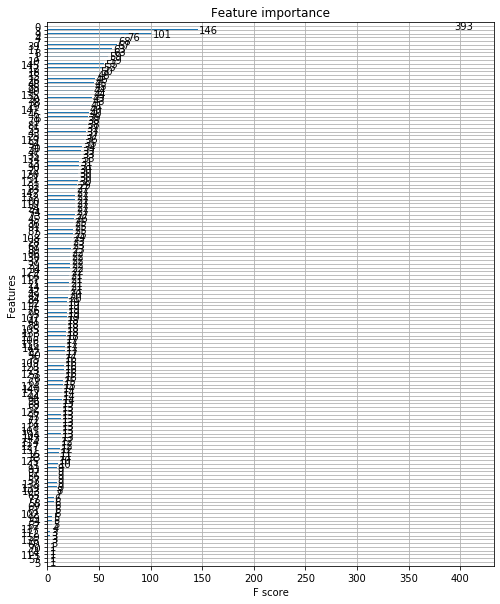

In [43]:
xgb.plot_importance(bst)

(array([ 4., 12., 13., 17.,  9.,  7.,  5.,  2.,  2.,  1.]),
 array([-3.03655925, -2.23636945, -1.43617965, -0.63598985,  0.16419995,
         0.96438975,  1.76457955,  2.56476935,  3.36495915,  4.16514895,
         4.96533875]),
 <a list of 10 Patch objects>)

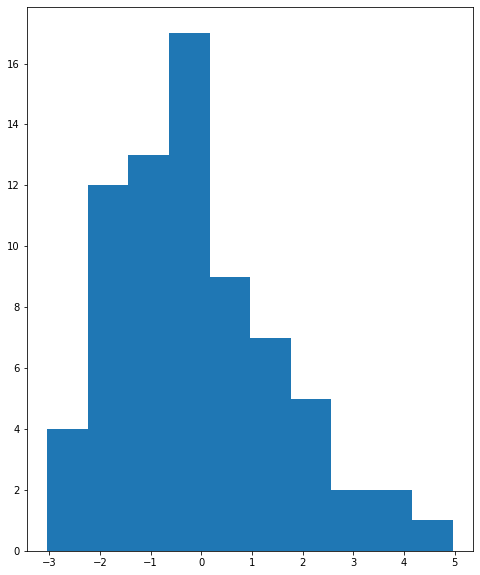

In [44]:
plt.hist((y_test.subtract(xgbPred))/1000000)

In [45]:
diff=y_test.subtract(xgbPred)
len(diff[abs(diff)<500000])

17

In [46]:
len(diff)

72

In [47]:
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-2411602.75
-295720.5
3004513.375
17


In [48]:
from sklearn.tree import DecisionTreeRegressor

dtree=DecisionTreeRegressor()
#dtree.fit(X2_train,y2_train)
dtree.fit(X_train,y_train)

#diff=dtree.predict(X2_test)-y2_test
diff=dtree.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)

(array([ 5.,  1.,  7., 10., 13., 21.,  6.,  5.,  1.,  3.]),
 array([-4250000., -3335000., -2420000., -1505000.,  -590000.,   325000.,
         1240000.,  2155000.,  3070000.,  3985000.,  4900000.]),
 <a list of 10 Patch objects>)

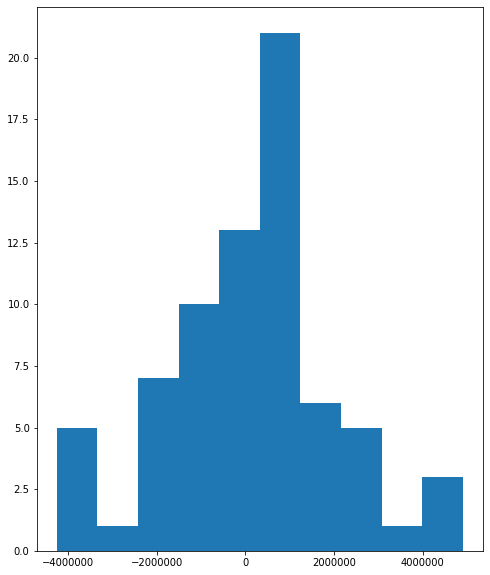

In [49]:
plt.hist(diff)

In [50]:
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-3500000.0
400000.0
3916667.0
14


In [51]:
#ksmooth
#mcluster
#additive modeles
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
svr.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [52]:
diff=svr.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
sum(diff)/len(y_test)

-34228.18416439002

In [53]:
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-4750000.099926416
149999.89855321962
3099999.898635693
21


In [54]:
len(y_test)

72

In [55]:
len(diff[abs(diff)<500000])/len(diff)

0.2916666666666667

In [56]:
from sklearn.linear_model import SGDRegressor

sgd=SGDRegressor(max_iter=1000, tol=1e-3)
sgd.fit(X_train,y_train)
sgd.score(X_test,y_test)

0.011253161342155038

In [57]:
diff=sgd.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-4634836.2168549895
219012.39946464542
3156052.850786969
21


In [58]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor()
model.fit(X_train,y_train)

diff=model.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

print(model.score(X_test,y_test))

-2763462.0
191667.0
2277222.3
19
0.4935272530760877


(array([ 3.,  0.,  2.,  6.,  7., 14., 15., 13.,  8.,  4.]),
 array([-4635000.1 , -3881916.76, -3128833.42, -2375750.08, -1622666.74,
         -869583.4 ,  -116500.06,   636583.28,  1389666.62,  2142749.96,
         2895833.3 ]),
 <a list of 10 Patch objects>)

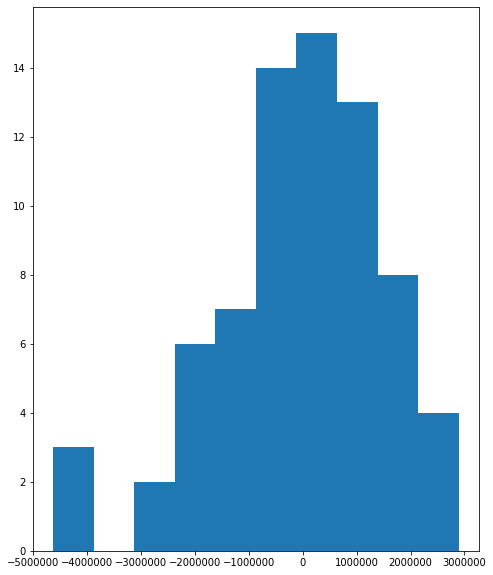

In [59]:
plt.hist(diff)

In [60]:
np.std(diff)

1535445.9644016577

In [61]:
model = BaggingRegressor()
model.fit(X2_train,y2_train)

diff=model.predict(X2_test)-y2_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

print(model.score(X2_test,y2_test))

-3082331.0
30000.0
2132500.0
19
0.5433454908571127


(array([ 2.,  3.,  1., 10.,  7., 14., 14.,  8.,  9.,  4.]),
 array([-3857500.  , -3192458.33, -2527416.66, -1862374.99, -1197333.32,
         -532291.65,   132750.02,   797791.69,  1462833.36,  2127875.03,
         2792916.7 ]),
 <a list of 10 Patch objects>)

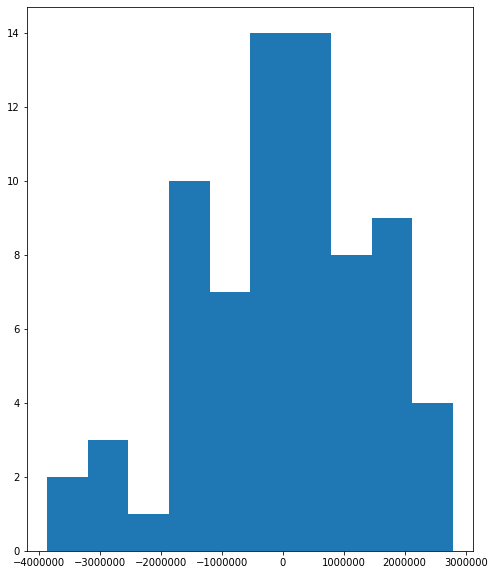

In [62]:
plt.hist(diff)

In [63]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=3000000).fit(X_train, y_train)
regr.predict(X_test)
regr.score(X_test, y_test)

0.5317528470741646

In [64]:
diff=regr.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-2865696.170995239
379726.6779576093
2160241.77472164
18
